In [ ]:
# prompt: load in this dataset from hugging face using python: https://huggingface.co/datasets/marcov/sms_spam_promptsource

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import time
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import Counter
from wordcloud import WordCloud
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
import psutil

import threading

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
data = pd.read_parquet("hf://datasets/marcov/sms_spam_promptsource/data/train-00000-of-00001.parquet")

data

,sms,label,template_name,template,rendered_input,rendered_output
0,"Go until jurong point, crazy.. Available only ...",0,ham_True_False,"Is this sms message considered {{""ham""}} (i.e....",Is this sms message considered ham (i.e. not s...,True
1,Ok lar... Joking wif u oni...\n,0,ham_True_False,"Is this sms message considered {{""ham""}} (i.e....",Is this sms message considered ham (i.e. not s...,True
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,ham_True_False,"Is this sms message considered {{""ham""}} (i.e....",Is this sms message considered ham (i.e. not s...,False
3,U dun say so early hor... U c already then say...,0,ham_True_False,"Is this sms message considered {{""ham""}} (i.e....",Is this sms message considered ham (i.e. not s...,True
4,"Nah I don't think he goes to usf, he lives aro...",0,ham_True_False,"Is this sms message considered {{""ham""}} (i.e....",Is this sms message considered ham (i.e. not s...,True
...,...,...,...,...,...,...
27865,This is the 2nd time we have tried 2 contact u...,1,spam_label,What is the spam label for the following sms m...,What is the spam label for the following sms m...,spam
27866,Will ü b going to esplanade fr home?\n,0,spam_label,What is the spam label for the following sms m...,What is the spam label for the following sms m...,not spam
27867,"Pity, * was in mood for that. So...any other s...",0,spam_label,What is the spam label for the following sms m...,What is the spam label for the following sms m...,not spam
27868,The guy did some bitching but I acted like i'd...,0,spam_label,What is the spam label for the following sms m...,What is the spam label for the following sms m...,not spam


In [ ]:
df = data[data['template_name'] == 'ham_True_False']
df = df.drop(columns=['template_name', 'template', 'rendered_input', 'rendered_output'])
df

,sms,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...\n,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0
...,...,...
5569,This is the 2nd time we have tried 2 contact u...,1
5570,Will ü b going to esplanade fr home?\n,0
5571,"Pity, * was in mood for that. So...any other s...",0
5572,The guy did some bitching but I acted like i'd...,0


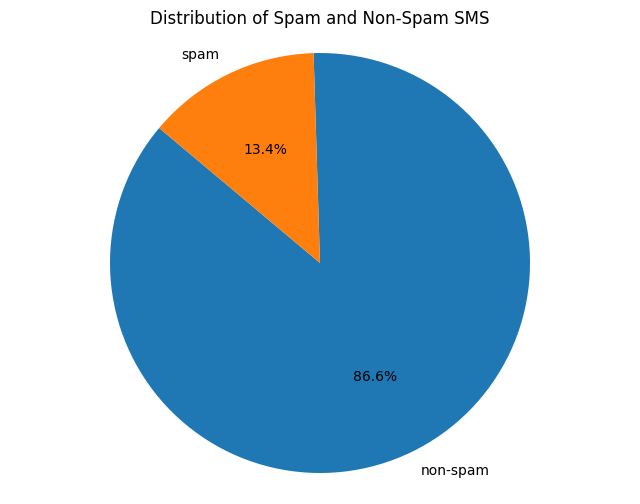

In [ ]:
df['label'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(df['label'].value_counts(), labels=['non-spam','spam'], autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Spam and Non-Spam SMS')
plt.axis('equal')
plt.show()

Average Length of Spam SMS: 139.6760374832664
Average Length of Ham SMS: 72.47192873420344


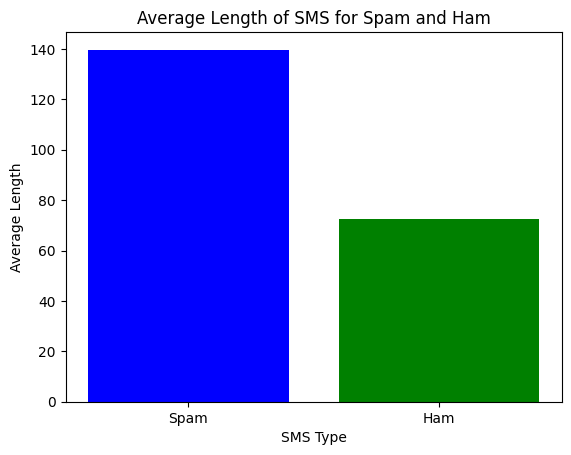

Average Number of Words in Spam SMS: 27.998661311914326
Average Number of Words in Ham SMS: 17.439196188108557


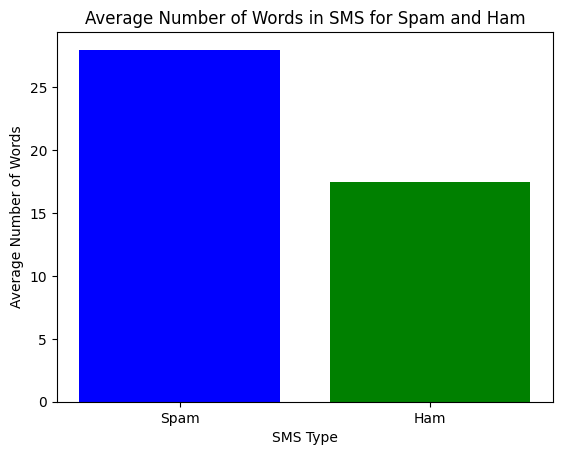

Average Number of Sentences in Spam SMS: 3.040160642570281
Average Number of Sentences in Ham SMS: 1.8458669981354878


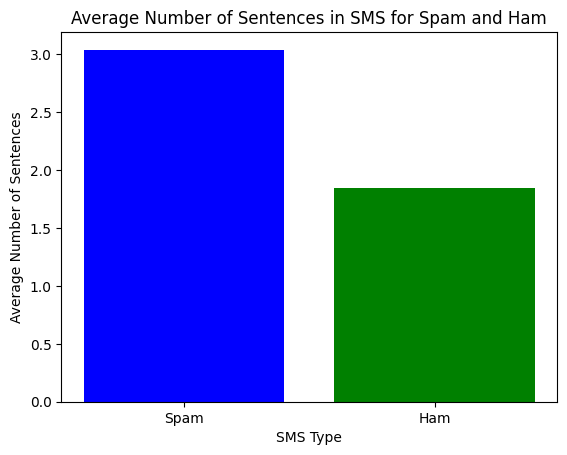

In [ ]:
df['Length_of_SMS'] = df['sms'].apply(len)
df['words_in_sms'] = df['sms'].apply(word_tokenize).apply(len)
df['sentences_in_sms'] = df['sms'].apply(sent_tokenize).apply(len)
df.head()

spam_length = df[df['label'] == 1]['Length_of_SMS'].mean()
ham_length = df[df['label'] == 0]['Length_of_SMS'].mean()

spam_words = df[df['label'] == 1]['words_in_sms'].mean()
ham_words = df[df['label'] == 0]['words_in_sms'].mean()

spam_sentences = df[df['label'] == 1]['sentences_in_sms'].mean()
ham_sentences = df[df['label'] == 0]['sentences_in_sms'].mean()

#plotting
print("Average Length of Spam SMS:", spam_length)
print("Average Length of Ham SMS:", ham_length)

plt.bar(['Spam', 'Ham'], [spam_length, ham_length], color=['Blue', 'green'])
plt.title('Average Length of SMS for Spam and Ham')
plt.xlabel('SMS Type')
plt.ylabel('Average Length')
plt.show()

print("Average Number of Words in Spam SMS:", spam_words)
print("Average Number of Words in Ham SMS:", ham_words)

plt.bar(['Spam', 'Ham'], [spam_words, ham_words], color=['Blue', 'green'])
plt.title('Average Number of Words in SMS for Spam and Ham')
plt.xlabel('SMS Type')
plt.ylabel('Average Number of Words')
plt.show()

print("Average Number of Sentences in Spam SMS:", spam_sentences)
print("Average Number of Sentences in Ham SMS:", ham_sentences)

plt.bar(['Spam', 'Ham'], [spam_sentences, ham_sentences], color=['Blue', 'green'])
plt.title('Average Number of Sentences in SMS for Spam and Ham')
plt.xlabel('SMS Type')
plt.ylabel('Average Number of Sentences')
plt.show()

The Relationship between Features are                    Length_of_SMS  words_in_sms  sentences_in_sms
Length_of_SMS          1.000000      0.966369          0.631125
words_in_sms           0.966369      1.000000          0.686283
sentences_in_sms       0.631125      0.686283          1.000000


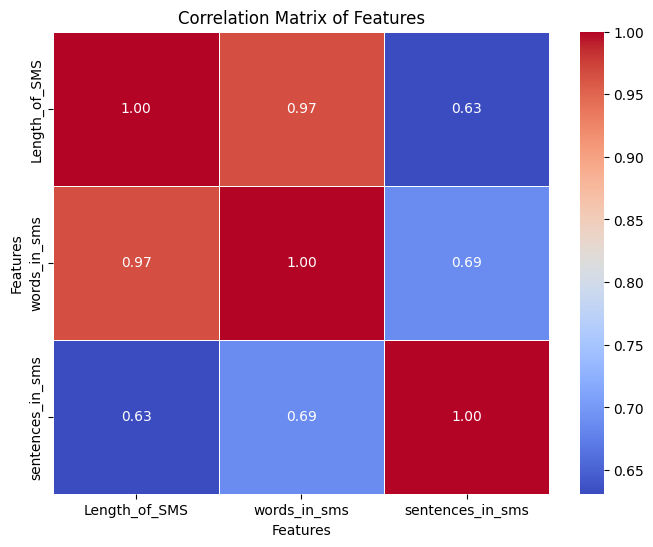

In [ ]:
correlation_matrix = df[['Length_of_SMS', 'words_in_sms', 'sentences_in_sms']].corr()
print("The Relationship between Features are ",correlation_matrix )
# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Features')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

In [ ]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    tokens = nltk.word_tokenize(text)  # Tokenize
    tokens = [token for token in tokens if token.isalnum()] #remove special characters
    tokens = [token for token in tokens if token not in stop_words]  # Remove stop words
    stemmer = nltk.PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens] # Stemming
    return " ".join(tokens)

df['processed_sms'] = df['sms'].apply(preprocess_text)
df


,sms,label,Length_of_SMS,words_in_sms,sentences_in_sms,processed_sms
0,"Go until jurong point, crazy.. Available only ...",0,112,24,2,go jurong point crazi avail bugi n great world...
1,Ok lar... Joking wif u oni...\n,0,30,8,2,ok lar joke wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,156,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,U dun say so early hor... U c already then say...,0,50,13,1,u dun say earli hor u c alreadi say
4,"Nah I don't think he goes to usf, he lives aro...",0,62,15,1,nah think goe usf live around though
...,...,...,...,...,...,...
5569,This is the 2nd time we have tried 2 contact u...,1,161,35,4,2nd time tri 2 contact u pound prize 2 claim e...
5570,Will ü b going to esplanade fr home?\n,0,37,9,1,ü b go esplanad fr home
5571,"Pity, * was in mood for that. So...any other s...",0,58,15,2,piti mood suggest
5572,The guy did some bitching but I acted like i'd...,0,126,27,1,guy bitch act like interest buy someth els nex...


Top 10 Most Common Words in Spam SMS:
call: 365 occurrences
free: 219 occurrences
2: 174 occurrences
txt: 169 occurrences
ur: 144 occurrences
u: 142 occurrences
text: 139 occurrences
mobil: 135 occurrences
4: 120 occurrences
stop: 118 occurrences


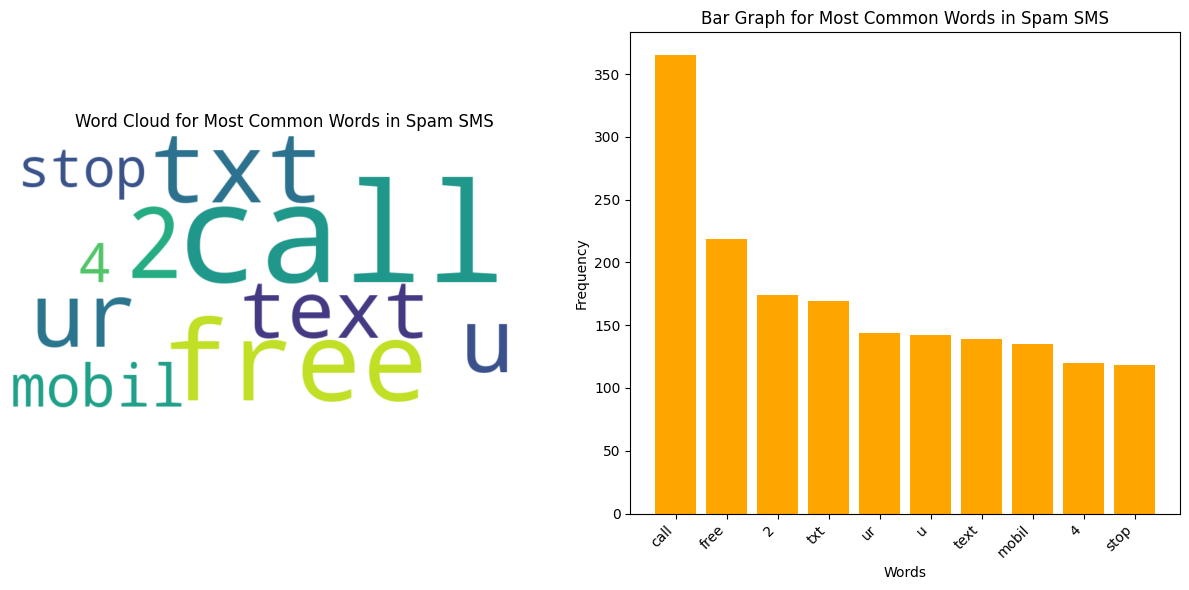

In [ ]:
spam = df[df['label'] == 1]['processed_sms']

spam_words = ' '.join(spam).split()

word_counts = Counter(spam_words)

most_common_words = word_counts.most_common(10)

print("Top 10 Most Common Words in Spam SMS:")
for word, count in most_common_words:
    print(f"{word}: {count} occurrences")

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(most_common_words))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Most Common Words in Spam SMS')
plt.axis('off')

# Plot Bar Graph
plt.subplot(1, 2, 2)
words, counts = zip(*most_common_words)
plt.bar(words, counts, color='orange')
plt.title('Bar Graph for Most Common Words in Spam SMS')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


Top 10 Most Common Words in Non-Spam SMS:
u: 994 occurrences
go: 420 occurrences
get: 359 occurrences
gt: 318 occurrences
lt: 316 occurrences
2: 304 occurrences
come: 298 occurrences
call: 293 occurrences
know: 249 occurrences
ur: 247 occurrences


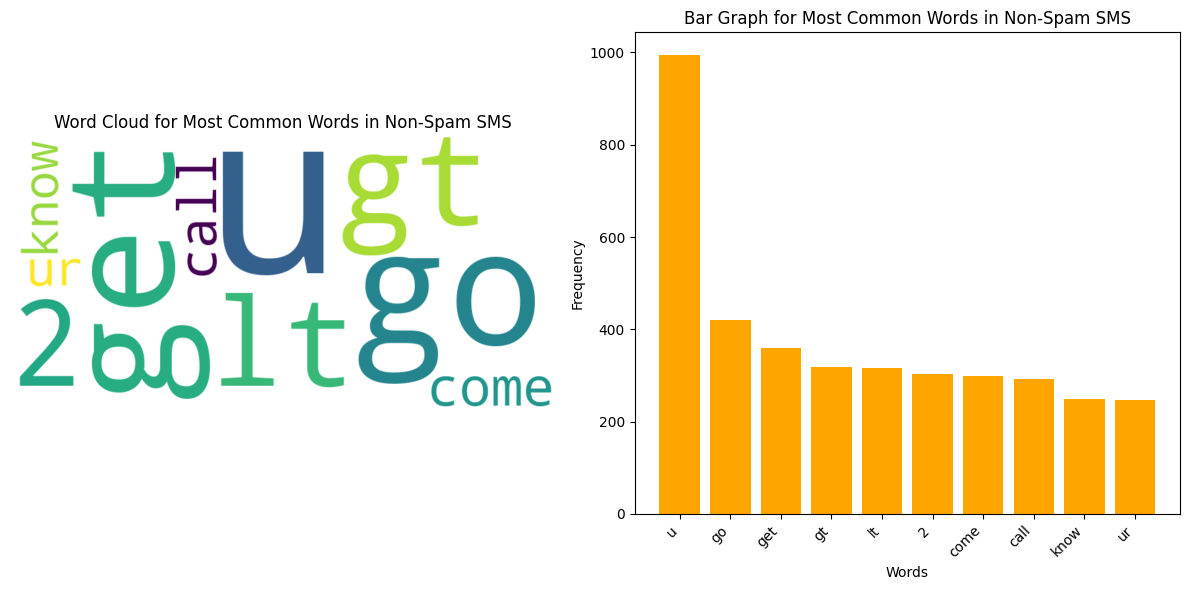

In [ ]:
ham = df[df['label'] == 0]['processed_sms']

ham_words = ' '.join(ham).split()

word_counts = Counter(ham_words)

most_common_words = word_counts.most_common(10)

print("Top 10 Most Common Words in Non-Spam SMS:")
for word, count in most_common_words:
    print(f"{word}: {count} occurrences")

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(most_common_words))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Most Common Words in Non-Spam SMS')
plt.axis('off')

# Plot Bar Graph
plt.subplot(1, 2, 2)
words, counts = zip(*most_common_words)
plt.bar(words, counts, color='orange')
plt.title('Bar Graph for Most Common Words in Non-Spam SMS')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


Data splitting and Vectorization

In [ ]:
encoder = LabelEncoder()
df['label'] = encoder.fit_transform(df['label'])
#data spliting and vectorization
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(df['processed_sms']).toarray()
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

SVM

In [ ]:
svc_classifier = SVC(probability=True)
# Start time and CPU usage tracking
start_time = time.time()
timestamps = []
cpu_usage = []

# Function to track CPU usage in a separate thread
def track_cpu_usage():
    while training_flag:
        cpu_usage.append(psutil.cpu_percent(interval=0.1))
        timestamps.append(time.time() - start_time)

# Start CPU tracking in a separate thread
training_flag = True
cpu_thread = threading.Thread(target=track_cpu_usage)
cpu_thread.start()

# Train the SVM model on the full training set
svc_classifier.fit(X_train, y_train)

# Stop CPU tracking
training_flag = False
cpu_thread.join()


y_pred_svc = svc_classifier.predict(X_test)
accuracy_svc = accuracy_score(y_test, y_pred_svc)
print(f"SVM Accuracy: {accuracy_svc:.4f}")
print("confusion Matrix :",confusion_matrix(y_test,y_pred_svc))
print("Precision Score: ",precision_score(y_test,y_pred_svc))
print("Classification Report: \n", classification_report(y_test, y_pred_svc))

SVM Accuracy: 0.9803
confusion Matrix : [[952   2]
 [ 20 141]]
Precision Score:  0.986013986013986
Classification Report: 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       954
           1       0.99      0.88      0.93       161

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



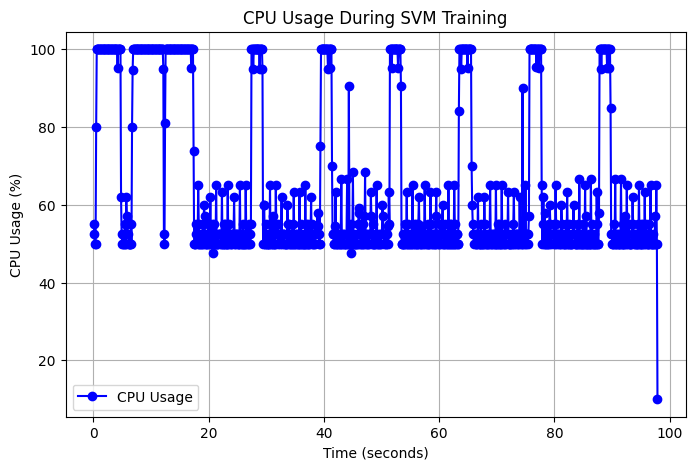

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(timestamps, cpu_usage, marker='o', linestyle='-', color='b', label="CPU Usage")
plt.xlabel("Time (seconds)")
plt.ylabel("CPU Usage (%)")
plt.title("CPU Usage During SVM Training")
plt.legend()
plt.grid(True)
plt.show()

<ipython-input-17-f7461a8ca923>:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


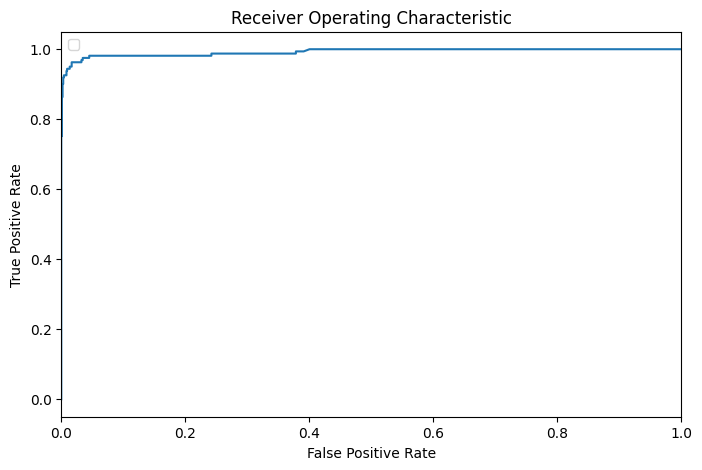

In [ ]:
# Plot ROC Curve
y_prob_svc = svc_classifier.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob_svc)
roc_auc = roc_auc_score(y_test, y_prob_svc)
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim(0.0,1.0)
plt.title("Receiver Operating Characteristic")
plt.legend()
plt.show()

SVM Accuracy: 0.9821
Confusion Matrix: [[951   3]
 [ 17 144]]
Precision Score: 0.9795918367346939
Classification Report:               precision    recall  f1-score   support

           0       0.98      1.00      0.99       954
           1       0.98      0.89      0.94       161

    accuracy                           0.98      1115
   macro avg       0.98      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115



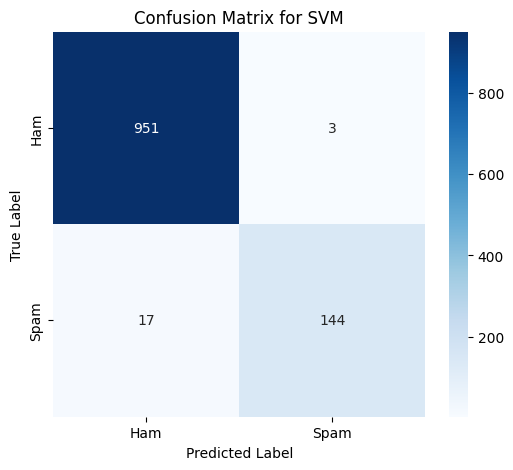

<ipython-input-46-9a77ff48926a>:61: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


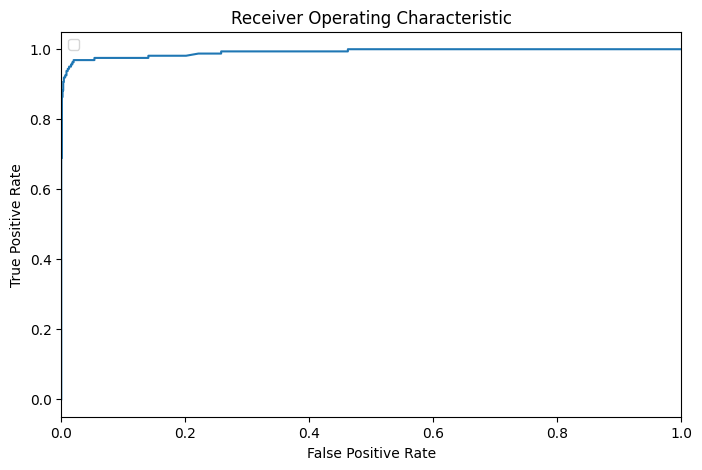

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, classification_report

# Initialize SVM model with probability estimates enabled
svc_classifier = SVC(kernel='linear', probability=True)  # Ensure probability=True before fitting
# Start time and CPU usage tracking
start_time = time.time()
timestamps = []
cpu_usage = []

# Function to track CPU usage in a separate thread
def track_cpu_usage():
    while training_flag:
        cpu_usage.append(psutil.cpu_percent(interval=0.1))
        timestamps.append(time.time() - start_time)

# Start CPU tracking in a separate thread
training_flag = True
cpu_thread = threading.Thread(target=track_cpu_usage)
cpu_thread.start()

# Train the SVM model on the full training set
svc_classifier.fit(X_train, y_train)

# Stop CPU tracking
training_flag = False
cpu_thread.join()

y_pred_svc = svc_classifier.predict(X_test)

# Evaluate model performance
accuracy_svc = accuracy_score(y_test, y_pred_svc)
print(f"SVM Accuracy: {accuracy_svc:.4f}")
print("Confusion Matrix:", confusion_matrix(y_test, y_pred_svc))
print("Precision Score:", precision_score(y_test, y_pred_svc))
print("Classification Report:", classification_report(y_test, y_pred_svc))

# Generate and plot confusion matrix
cm = confusion_matrix(y_test, y_pred_svc)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for SVM")
plt.show()

# Plot ROC Curve
y_prob_svc = svc_classifier.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob_svc)
roc_auc = roc_auc_score(y_test, y_prob_svc)
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim(0.0,1.0)
plt.title("Receiver Operating Characteristic")
plt.legend()
plt.show()

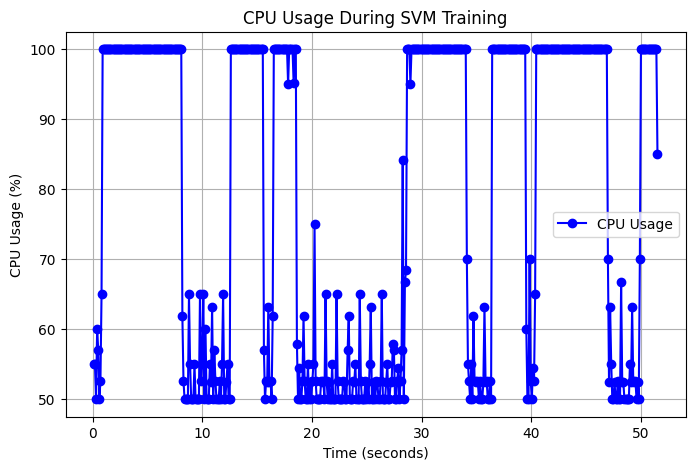

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(timestamps, cpu_usage, marker='o', linestyle='-', color='b', label="CPU Usage")
plt.xlabel("Time (seconds)")
plt.ylabel("CPU Usage (%)")
plt.title("CPU Usage During SVM Training")
plt.legend()
plt.grid(True)
plt.show()

## Neural Network

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.8318 - loss: 0.4994 - val_accuracy: 0.8924 - val_loss: 0.1917
Epoch 2/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9572 - loss: 0.1201 - val_accuracy: 0.9697 - val_loss: 0.0909
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9937 - loss: 0.0295 - val_accuracy: 0.9709 - val_loss: 0.0976
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9960 - loss: 0.0179 - val_accuracy: 0.9731 - val_loss: 0.1065
Epoch 5/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9984 - loss: 0.0078 - val_accuracy: 0.9720 - val_loss: 0.1177
Epoch 6/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9992 - loss: 0.0036 - val_accuracy: 0.9709 - val_loss: 0.1217
Epoch 7/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9995 - loss: 0.0042 - val_accuracy: 0.9709 - val_loss: 0.1334
Epoch 8/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9997 - loss: 0.0031 - val_accuracy: 0.9686 - val

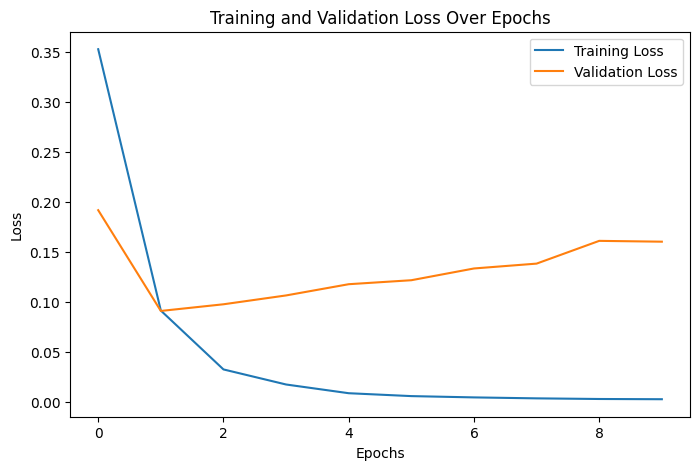

InvalidParameterError: The 'y_pred' parameter of confusion_matrix must be an array-like. Got 0.9802690744400024 instead.

In [ ]:
#NeoroNetwork
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
# Start time and CPU usage tracking
start_time = time.time()
timestamps = []
cpu_usage = []

# Function to track CPU usage in a separate thread
def track_cpu_usage():
    while training_flag:
        cpu_usage.append(psutil.cpu_percent(interval=0.1))
        timestamps.append(time.time() - start_time)

# Start CPU tracking in a separate thread
training_flag = True
cpu_thread = threading.Thread(target=track_cpu_usage)
cpu_thread.start()


history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Stop CPU tracking
training_flag = False
cpu_thread.join()
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_acc:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Generate and plot confusion matrix
cm = confusion_matrix(y_test, test_acc)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for NN")
plt.show()


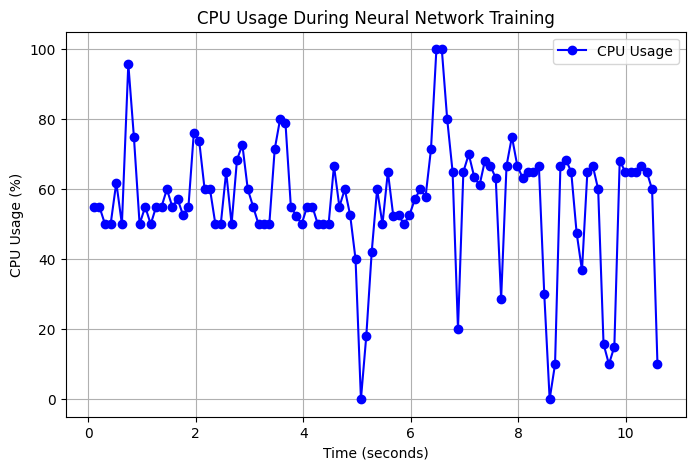

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(timestamps, cpu_usage, marker='o', linestyle='-', color='b', label="CPU Usage")
plt.xlabel("Time (seconds)")
plt.ylabel("CPU Usage (%)")
plt.title("CPU Usage During Neural Network Training")
plt.legend()
plt.grid(True)
plt.show()

## Feed-Forward Neural Network
This program uses Dropout, L2 regularization, batch normalization, and other techniques to prevent overfitting

Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.6865 - loss: 1.5316 - val_accuracy: 0.8556 - val_loss: 0.9035
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9655 - loss: 0.6459 - val_accuracy: 0.8556 - val_loss: 0.7014
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9828 - loss: 0.3989 - val_accuracy: 0.8789 - val_loss: 0.5064
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9868 - loss: 0.2766 - val_accuracy: 0.9354 - val_loss: 0.3506
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9904 - loss: 0.2103 - val_accuracy: 0.9794 - val_loss: 0.2099
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9864 - loss: 0.2016 - val_accuracy: 0.9830 - val_loss: 0.1937
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9928 - loss: 0.1541 - val_accuracy: 0.9812 - val_loss: 0.1927
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9919 - loss: 0.1431 - val_accuracy: 0

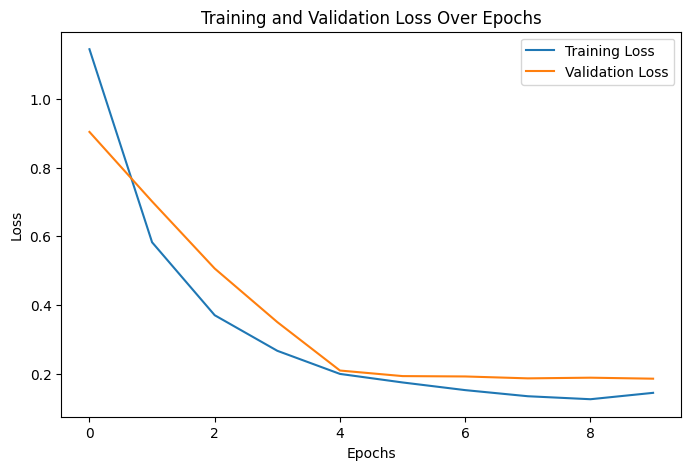

Final Test Accuracy: 0.9803


In [ ]:
model = keras.Sequential([
    layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01), input_shape=(X_train.shape[1],)),  # First hidden layer with L2 regularization
    layers.BatchNormalization(),  # Batch Normalization
    layers.Dropout(0.3),  # Dropout layer (30%) to prevent overfitting
    layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),  # Second hidden layer with L2 regularization
    layers.BatchNormalization(),  # Batch Normalization
    layers.Dropout(0.3),  # Dropout layer (30%)
    layers.Dense(1, activation='sigmoid')  # Output layer with Sigmoid
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early Stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Start time and CPU usage tracking
start_time = time.time()
timestamps = []
cpu_usage = []

# Function to track CPU usage in a separate thread
def track_cpu_usage():
    while training_flag:
        cpu_usage.append(psutil.cpu_percent(interval=0.1))
        timestamps.append(time.time() - start_time)

# Start CPU tracking in a separate thread
training_flag = True
cpu_thread = threading.Thread(target=track_cpu_usage)
cpu_thread.start()

# Train with Early Stopping
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Stop CPU tracking
training_flag = False
cpu_thread.join()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

print(f"Final Test Accuracy: {test_accuracy:.4f}")




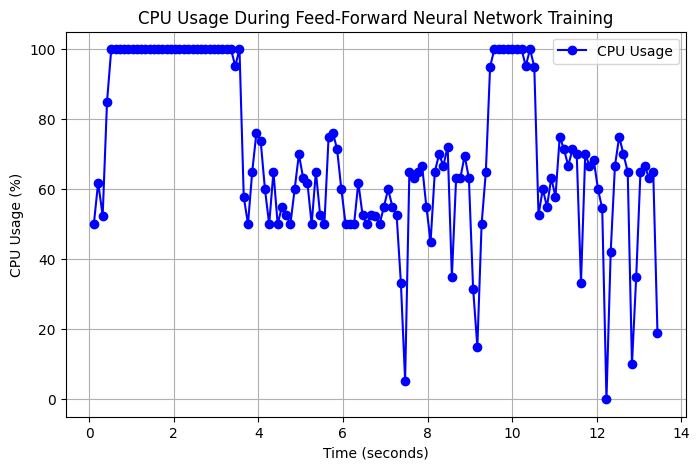

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(timestamps, cpu_usage, marker='o', linestyle='-', color='b', label="CPU Usage")
plt.xlabel("Time (seconds)")
plt.ylabel("CPU Usage (%)")
plt.title("CPU Usage During Feed-Forward Neural Network Training")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Random Forest
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
#tfidf = TfidfVectorizer(max_features=3000)
#X = tfidf.fit_transform(df['processed_sms']).toarray()
#y = df['label']

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)

# Stop CPU tracking
y_pred_rf = rf_classifier.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_rf),
                                                  display_labels=['ham','spam'])

print(f"Random Forest Accuracy: {accuracy_rf:.4f}")
print("Confusion Matrix :",confusion_matrix(y_test,y_pred_rf))
print("Precision Score: ",precision_score(y_test,y_pred_rf))
print("Classification Report: \n", classification_report(y_test, y_pred_rf))

confusion_matrix_display.plot()
plt.show()

NameError: name 'time' is not defined

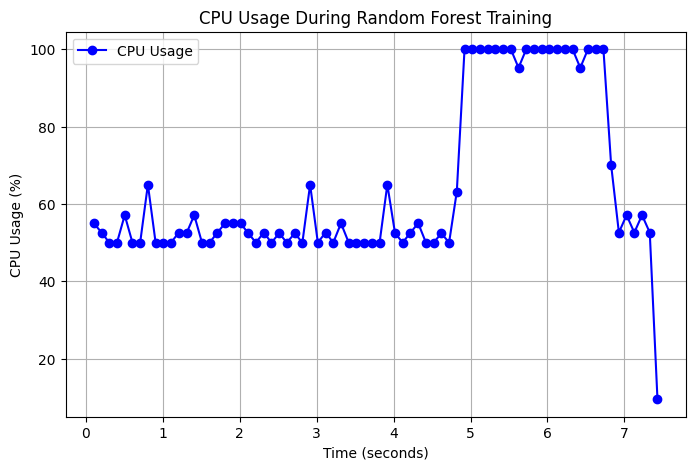

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(timestamps, cpu_usage, marker='o', linestyle='-', color='b', label="CPU Usage")
plt.xlabel("Time (seconds)")
plt.ylabel("CPU Usage (%)")
plt.title("CPU Usage During Random Forest Training")
plt.legend()
plt.grid(True)
plt.show()


Best Model: alpha=0.2, fit_prior=True with Accuracy: 0.9821

Confusion Matrix for Best Model:
[[952   2]
 [ 18 143]]

Classification Report for Best Model:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       954
           1       0.99      0.89      0.93       161

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



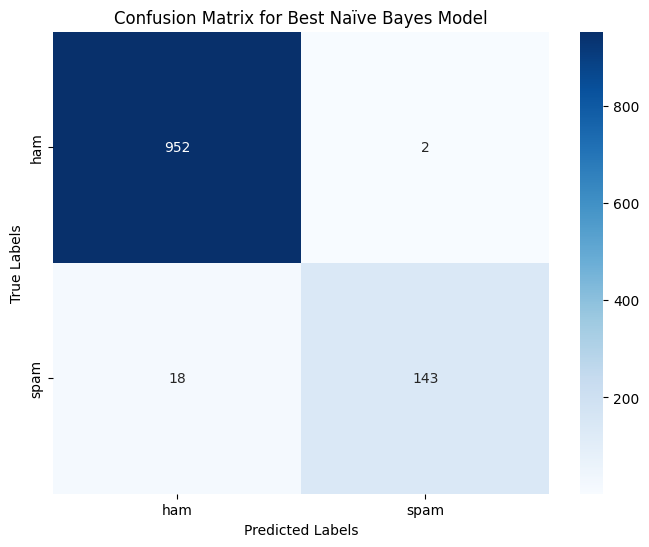

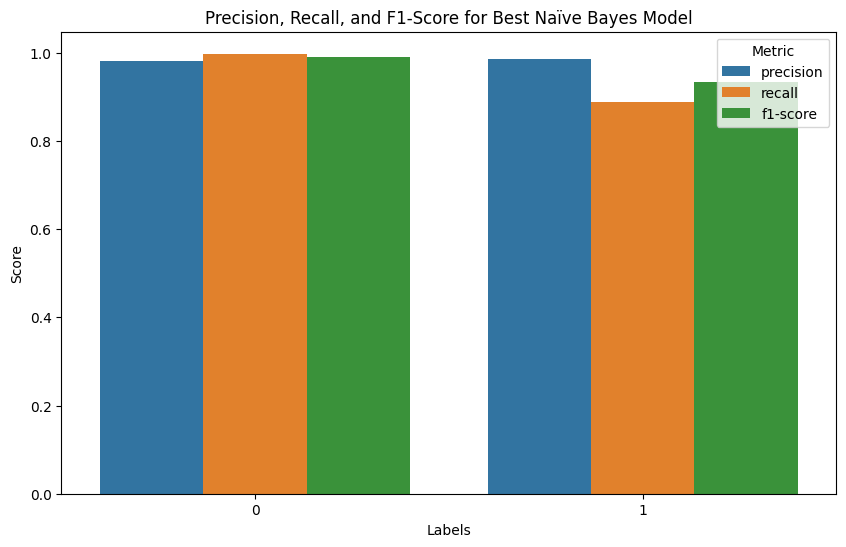

Best model accuracy: 98.21%
95% Confidence Interval: [97.49%, 98.92%]


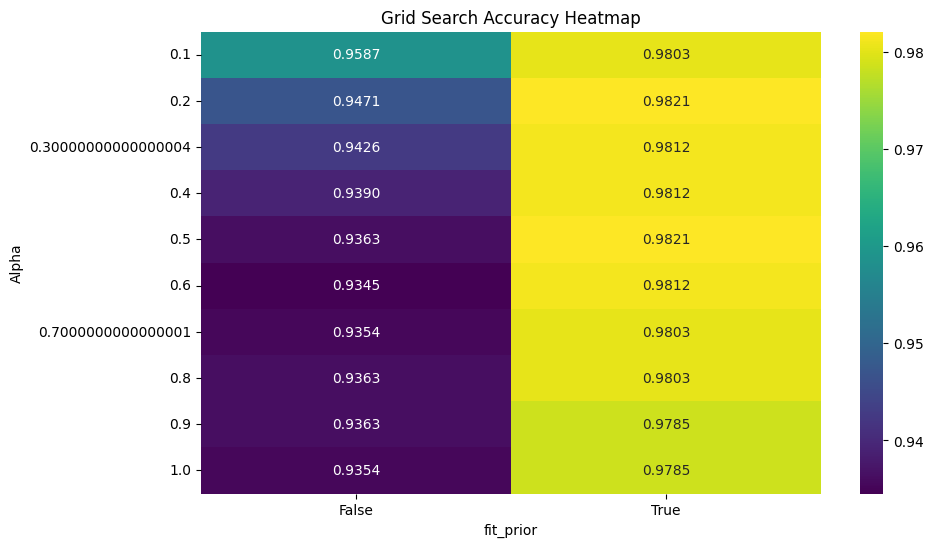

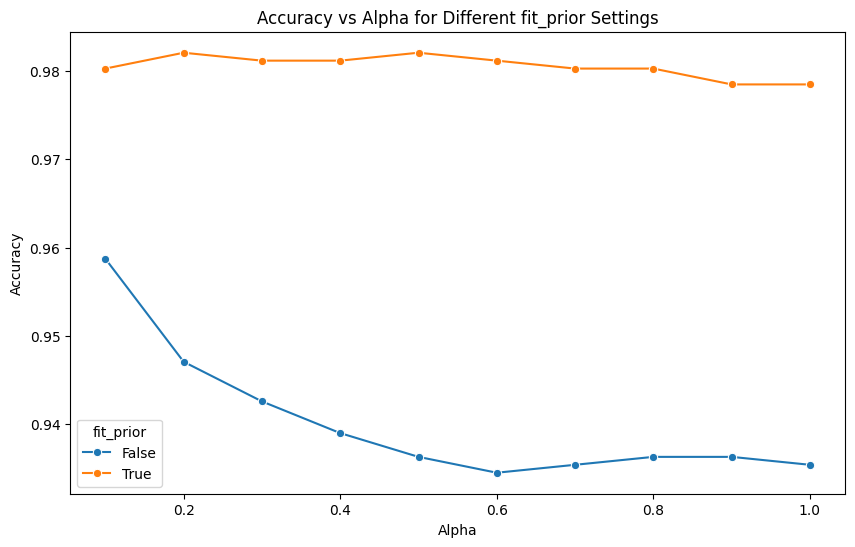

In [ ]:
#NAIVE BAYES
best_accuracy = 0
best_model = None
best_alpha = None
best_fit_prior = None
best_cm = None
best_classification_report = None

results = []

start_time = time.time()
timestamps = []
cpu_usage = []

def track_cpu_usage():
    while training_flag:
        cpu_usage.append(psutil.cpu_percent(interval=0.1))
        timestamps.append(time.time() - start_time)

training_flag = True
cpu_thread = threading.Thread(target=track_cpu_usage)
cpu_thread.start()

for alpha in np.arange(0.1, 1.1, 0.1):
    for fit_prior in [True, False]:
        nb_model = MultinomialNB(alpha=alpha, fit_prior=fit_prior)
        nb_model.fit(X_train, y_train)

        y_pred_nb = nb_model.predict(X_test)
        accuracy_nb = accuracy_score(y_test, y_pred_nb)

        results.append({'alpha': alpha, 'fit_prior': fit_prior, 'accuracy': accuracy_nb})

        if accuracy_nb > best_accuracy:
            best_accuracy = accuracy_nb
            best_model = nb_model
            best_alpha = alpha
            best_fit_prior = fit_prior
            best_cm = confusion_matrix(y_test, y_pred_nb)
            best_classification_report = classification_report(y_test, y_pred_nb, output_dict=True)

training_flag = False
cpu_thread.join()

print(f"\nBest Model: alpha={best_alpha}, fit_prior={best_fit_prior} with Accuracy: {best_accuracy:.4f}")
print("\nConfusion Matrix for Best Model:")
print(best_cm)
print("\nClassification Report for Best Model:")
print(classification_report(y_test, best_model.predict(X_test)))

plt.figure(figsize=(8, 6))
sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['ham','spam'], yticklabels=['ham','spam'])
plt.title("Confusion Matrix for Best Naïve Bayes Model")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

metrics_df = pd.DataFrame(best_classification_report).transpose().drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')
metrics_df = metrics_df.reset_index().rename(columns={'index': 'Label'})

melted_df = pd.melt(metrics_df, id_vars='Label', value_vars=['precision', 'recall', 'f1-score'],
                    var_name='Metric', value_name='Score')

plt.figure(figsize=(10, 6))
sns.barplot(data=melted_df, x='Label', y='Score', hue='Metric')
plt.title("Precision, Recall, and F1-Score for Best Naïve Bayes Model")
plt.xlabel("Labels")
plt.ylabel("Score")
plt.legend(title='Metric')
plt.show()


def bootstrap_accuracy(y_true, y_pred, n_bootstraps=1000, seed=42):
    np.random.seed(seed)
    n = len(y_true)
    bootstrapped_scores = []
    for _ in range(n_bootstraps):
        indices = np.random.randint(0, n, n)
        score = accuracy_score(np.array(y_true)[indices], np.array(y_pred)[indices])
        bootstrapped_scores.append(score)
    lower = np.percentile(bootstrapped_scores, 2.5)
    upper = np.percentile(bootstrapped_scores, 97.5)
    return lower, upper

y_pred_best = best_model.predict(X_test)
ci_lower, ci_upper = bootstrap_accuracy(y_test, y_pred_best)
print(f"Best model accuracy: {best_accuracy:.2%}")
print(f"95% Confidence Interval: [{ci_lower:.2%}, {ci_upper:.2%}]")

results_df = pd.DataFrame(results)

pivot_table = results_df.pivot(index='alpha', columns='fit_prior', values='accuracy')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='viridis', fmt=".4f")
plt.title("Grid Search Accuracy Heatmap")
plt.xlabel("fit_prior")
plt.ylabel("Alpha")
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='alpha', y='accuracy', hue='fit_prior', marker="o")
plt.title("Accuracy vs Alpha for Different fit_prior Settings")
plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.show()


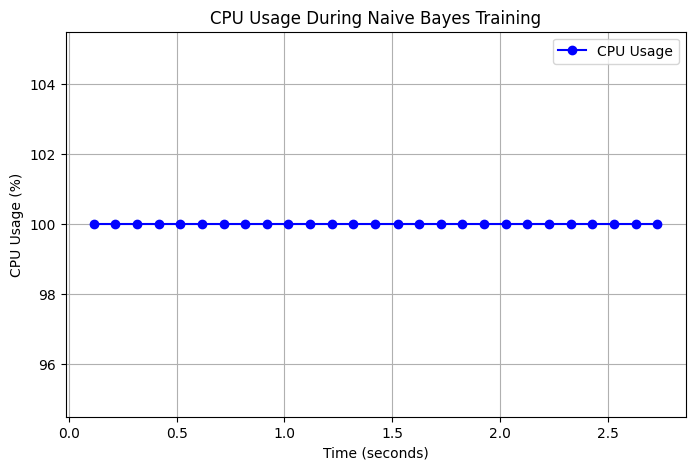

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(timestamps, cpu_usage, marker='o', linestyle='-', color='b', label="CPU Usage")
plt.xlabel("Time (seconds)")
plt.ylabel("CPU Usage (%)")
plt.title("CPU Usage During Naive Bayes Training")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
y_prob_nb = nb_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob_nb)
roc_auc = roc_auc_score(y_test, y_prob_nb)
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim(0.0,1.0)
plt.title("Receiver Operating Characteristic")
plt.legend()
plt.show()